# Validación cruzada y métodos de evaluación de rendimiento

In [12]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
import matplotlib.pyplot as plt

iris = load_iris()
X, y = iris.data, iris.target

classifier = KNeighborsClassifier()

Las etiquetas en iris están ordenadas, lo que significa que si partimos los datos de forma directa, el primer fold solo tendrá etiquetas de la clase 0, mientras que el último solo tendrá etiquetas de la clase 2:

In [2]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Para evitar este problema, podemos barajar los datos previamente:

In [3]:
import numpy as np
rng = np.random.RandomState(0)

permutation = rng.permutation(len(X))
X, y = X[permutation], y[permutation]
print(y)

[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1
 2 0]


Como la validación cruzada es muy común en aprendizaje automático, hay funciones para hacer todo lo anterior de forma más flexible y con menos código. El paquete ``sklearn.model_selection`` contiene todas las funciones relacionadas con validación cruzada. La función más sencilla es ``cross_val_score`` que recibe un estimador y un dataset y hace todo el proceso de forma automática:

In [4]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X, y)
print(scores)
print(np.mean(scores))

[ 0.98039216  0.98039216  0.95833333]
0.973039215686


Como puedes comprobar, por defecto, se utiliza $k=3$. Puedes cambiar el número de folds con el argumento `cv`:

In [5]:
cross_val_score(classifier, X, y, cv=5)

array([ 1.        ,  0.93333333,  1.        ,  1.        ,  0.93333333])

Además, hay objetos de ayuda en el módulo de validación cruzada que generan los índices para todos los métodos de validación cruzada, incluyendo $k$-fold:

In [6]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit

Por defecto, `cross_val_score` utiliza ``StratifiedKFold`` para clasificación, que asegura que la proporción de patrones por clase se respeta en cada fold. Si tenemos un dataset de clasificación binaria con un 90% de patrones de la clase 0, esto significa que en cada fold debería haber un 90% de patrones en la clase 0. Si utilizásemos el método ``KFold`` estándar, sería bastante probable que alguno de los folds tuviese solo patrones de la clase 0. En general, es recomendable utilizar siempre ``StratifiedKFold`` cuando estemos en un problema de clasificación.

``StratifiedKFold`` también nos evita la necesidad de barajar los datos, aunque por defecto esta opción no está activa. Veamos que tipo de folds nos genera en el dataset iris. Cada clase de validación cruzada actúa como un generador de índices de entrenamiento y test:

In [7]:
cv = StratifiedKFold(n_splits=5)
for train, test in cv.split(iris.data, iris.target):
    print(test)

[  0   1   2   3   4   5   6   7   8   9  50  51  52  53  54  55  56  57
  58  59 100 101 102 103 104 105 106 107 108 109]
[ 10  11  12  13  14  15  16  17  18  19  60  61  62  63  64  65  66  67
  68  69 110 111 112 113 114 115 116 117 118 119]
[ 20  21  22  23  24  25  26  27  28  29  70  71  72  73  74  75  76  77
  78  79 120 121 122 123 124 125 126 127 128 129]
[ 30  31  32  33  34  35  36  37  38  39  80  81  82  83  84  85  86  87
  88  89 130 131 132 133 134 135 136 137 138 139]
[ 40  41  42  43  44  45  46  47  48  49  90  91  92  93  94  95  96  97
  98  99 140 141 142 143 144 145 146 147 148 149]


Como puedes ver, siempre hay unos cuantos ejemplos del principio (primera clase), unos cuantos de la mitad (segunda clase) y otros cuantos del final (tercera clase), y así mantenemos la distribución de patrones por clase. Visualicemos la partición:

In [8]:
def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.matshow(masks, cmap='gray_r')

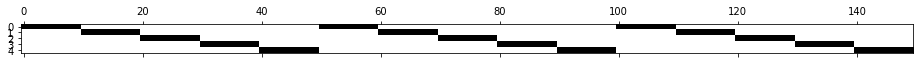

In [13]:
plot_cv(StratifiedKFold(n_splits=5), iris.data, iris.target)

Veamos lo que sucede con el ``KFold`` estándar, que ignora la distribución de patrones por clase.

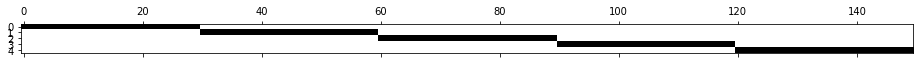

In [14]:
plot_cv(KFold(n_splits=5), iris.data, iris.target)

Recuerda que incrementar el número de folds te dará un conjunto de entrenamiento más grande y una evaluación más robusta, pero también te llevará a la necesidad de hacer más repeticiones y el proceso será más lento:

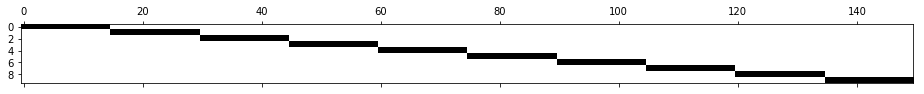

In [15]:
plot_cv(KFold(n_splits=10), iris.data, iris.target)

Otro generador de particiones de validación cruzada bastante útil es el ``ShuffleSplit``. Este generador simplemente parte los datos aleatoriamente varias veces, sin considerar folds. Esto permite que el usuario pueda especificar el número de repeticiones y el tamaño del conjunto de entrenamiento de forma independiente:

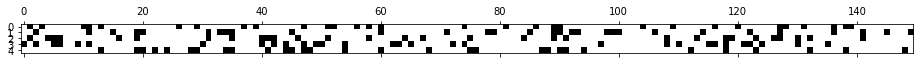

In [16]:
plot_cv(ShuffleSplit(n_splits=5, test_size=.2), iris.data, iris.target)

Si quieres una evaluación más robusta, bastaría con que incrementases el número de particiones:

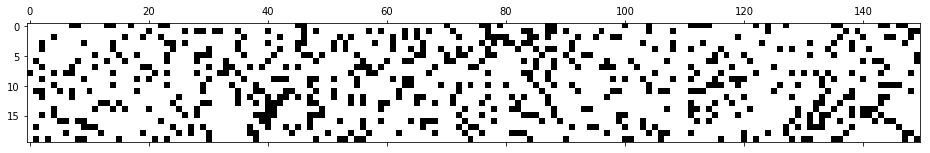

In [17]:
plot_cv(ShuffleSplit(n_splits=20, test_size=.2), iris.data, iris.target)

Cualquiera de estos métodos de validación cruzada se pueden combinar con el `cross_val_score`:

In [18]:
cv = ShuffleSplit(n_splits=5, test_size=.2)
cross_val_score(classifier, X, y, cv=cv)

array([ 0.96666667,  1.        ,  1.        ,  1.        ,  1.        ])